# Human Value Detection

## Imports

In [1]:
import os.path
%load_ext autoreload
%autoreload 2

from utilities import *
from models.bertOne import BertOne
from models.berTwo import BerTwo
from models.berThree import BerThree

from sklearn.metrics import accuracy_score
from models.randomUniformClassifier import RandomUniformClassifier
from models.majorityCalssifier import MajorityClassifier

import transformers

from drTorch.callbacks import EarlyStopper
from drTorch.metrics import F1_Score_Multi_Labels
from drTorch.utilities import *
from drTorch.wrappers import OptimizerWrapper
from drTorch.wrappers import Criterion
from drTorch.model_selection import grid_search_train_validation

import numpy as np
import torch


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('Device: %s' % device)


Device: cuda


## Defining constants and flags

In [3]:
# PATHS AND DATAFRAME CREATION
DATA_DIR = "data"
ARGUMENTS_DIR = os.path.join(DATA_DIR, "arguments")
LABELS_DIR = os.path.join(DATA_DIR, "labels")

BERT_MODELS_DIRECTORY = "bert_models"


# CONSTANTS 
N_LABELS = 4
N_CLASSES = 2
BATCH_SIZE_C = 32
BATCH_SIZE_CP = 8
BATCH_SIZE_CPS = 8

BERT_VERSIONS=["bert-base-uncased", "roberta-base"]
MODEL_CONSTRUCTORS = {'bert-base-uncased': transformers.BertModel, 'roberta-base': transformers.RobertaModel}
MODEL_TOKENIZER_CONSTRUCTORS = {'bert-base-uncased': transformers.BertTokenizer, 'roberta-base':transformers.RobertaTokenizer}

MODEL_INPUT = {"C":["Conclusion"], "CP":["Conclusion", "Premise"], "CPS":["Conclusion", "Premise", "Stance"]}
MODEL_BATCH_SIZES = {"C": BATCH_SIZE_C, "CP": BATCH_SIZE_CP, "CPS": BATCH_SIZE_CPS}
MODEL_DATASET_BUILDERS = {"C":CustomDataset_C, "CP": CustomDataset_CP, "CPS": CustomDataset_CPS}


RUN_RANDOM_CLF = False
RUN_MAJORITY_CLF = False
FIT_BERTONE = True
FIT_BERTWO = False
FIT_BERTHREE = False


CLASS_2_ONE_HOT = {class_label: np.eye(N_CLASSES)[i].astype(float).tolist() for i, class_label in enumerate(range(N_CLASSES))}



## Task 1

### Visualizing the data

In [4]:
# convert files in dataframes
train_arg_df, val_arg_df, test_arg_df = create_dfs(ARGUMENTS_DIR)
train_labels_df, val_labels_df, test_labels_df = create_dfs(LABELS_DIR)

print("Let's visualize the data: ")
display(train_arg_df.head(5))
display(train_labels_df.head(5))


Let's visualize the data: 


,Conclusion,Stance,Premise
Argument ID,,,
A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
A01008,We should ban factory farming,against,factory farming allows for the production of c...


,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
Argument ID,,,,,,,,,,,,,,,,,,,,
A01002,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
A01005,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
A01006,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
A01007,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
A01008,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


### Mapping labels to level-3 categories

In [5]:
mapping = define_mapping()
train_labels_df, val_labels_df, test_labels_df = map_to_level_3(mapping, train_labels_df, val_labels_df, test_labels_df) 

print("The training labels after the mapping are the following: ")
train_labels_df


The training labels after the mapping are the following: 


,Openess_to_change,Self_enhancement,Conservation,Self_transcendence
Argument ID,,,,
A01002,0,0,1,0
A01005,0,0,1,0
A01006,0,1,1,0
A01007,0,0,1,0
A01008,0,0,1,1
...,...,...,...,...
E08016,0,1,1,1
E08017,0,0,1,1
E08018,0,0,0,1


### One-hot encoding, tokenization and data loaders building

In [6]:
if os.path.exists(BERT_MODELS_DIRECTORY):
    bert_versions_paths = [os.path.join(BERT_MODELS_DIRECTORY, version)for version in BERT_VERSIONS]
else:    
    bert_versions_paths = download_bert_models(BERT_MODELS_DIRECTORY, BERT_VERSIONS, MODEL_CONSTRUCTORS, MODEL_TOKENIZER_CONSTRUCTORS)  
    

In [7]:
print(bert_versions_paths)

['bert_models/bert-base-uncased', 'bert_models/roberta-base']


In [8]:
model_inputs = {"C":["Conclusion"], "CP":["Conclusion", "Premise"], "CPS":["Conclusion", "Premise", "Stance"]}

dataloaders = {}

for model_path,in bert_versions_paths:
    model_name = os.path.basename(model_path)
    dataloaders[model_name]={}
    for model_key in model_inputs.keys():
        dataloaders[model_name][model_key]={}
     
        dataloader_train, dataloader_val, dataloader_test = build_dataloaders(train_df=train_arg_df, 
                                                                              val_df=val_arg_df, 
                                                                              test_df=test_arg_df, 
                                                                              train_labels_df=train_labels_df, 
                                                                              val_labels_df=val_labels_df, 
                                                                              test_labels_df=test_labels_df, 
                                                                              one_hot_mapping=CLASS_2_ONE_HOT, 
                                                                              bert_version=model_path, 
                                                                              tokenizer_constructor=MODEL_TOKENIZER_CONSTRUCTORS[model_name],
                                                                              model_input=model_inputs[model_key],
                                                                              custom_dataset_builder=MODEL_DATASET_BUILDERS[model_key],
                                                                              batch_size=MODEL_BATCH_SIZES[model_key], 
                                                                              shuffle=True)  
        dataloaders[model_name][model_key]['train'] = dataloader_train
        dataloaders[model_name][model_key]['val'] = dataloader_val
        dataloaders[model_name][model_key]['test'] = dataloader_test



"""for batch , input in dataloaders['bert-base-uncased']['C']['train']:
    print(batch.keys())
    break""";


## Task 2 

### Models Definition

####  1) Random uniform classifier

In [9]:
if RUN_RANDOM_CLF:
    # Create an instance of the random uniform classifier
    random_classifier = RandomUniformClassifier(N_LABELS)
    
    # Make predictions on the test set
    predicted_labels = random_classifier.predict(test_arg_df)
    
    # Accuracy of the Random Classifier
    accuracy = accuracy_score(test_labels_df, predicted_labels)
    print(f'Accuracy of the model over all the classes: {accuracy}\n')
    
    # F1 scores on the different labels singularly taken 
    f1_scorer = F1_Score_Multi_Labels(name='F1_macro_avg', num_labels=N_LABELS, num_classes=N_CLASSES, compute_mean=False)
    f1_scores_random_classifier = f1_scorer(torch.tensor(test_labels_df.values.tolist()), torch.tensor(predicted_labels))
    # AVG f1 score
    f1_avg_random_classifier = np.average(f1_scores_random_classifier)
    
    
    for idx, f1_score in enumerate(f1_scores_random_classifier):
        print(f" - {train_labels_df.columns[idx]} F1: {f1_score}")
    
    print(f'\nAverage F1: {f1_avg_random_classifier}')


####  2) Majority classifier

In [10]:
if RUN_MAJORITY_CLF:
    majority_classifier = MajorityClassifier()
    
    # Train the majority classifier (even though in practice, no training is needed)
    majority_classifier.fit(train_labels_df)
    
    # Make predictions on the test set
    predicted_labels = majority_classifier.predict(test_labels_df)
    
    # Accuracy of the Majority Classifier
    accuracy = accuracy_score(test_labels_df, predicted_labels)
    print(f'Accuracy of the model over all the classes: {accuracy}\n')
    
    # F1 scores on the different labels singularly taken 
    f1_scorer = F1_Score_Multi_Labels(name='F1_macro_avg', num_labels=N_LABELS, num_classes=N_CLASSES, compute_mean=False)
    f1_scores_majority_classifier = f1_scorer(torch.tensor(test_labels_df.values.tolist()), torch.tensor(predicted_labels))
    # AVG F1 score
    f1_avg_majority_classifier = np.average(f1_scores_majority_classifier)
    
    
    for idx, f1_score in enumerate(f1_scores_majority_classifier):
        print(f" - {train_labels_df.columns[idx]} F1: {f1_score}")
    
    print(f'\nAverage F1: {f1_avg_majority_classifier}')


####  3) Bert w/C

##### Searching the hyperparameters for bert w/C

In [14]:
"""
if RUN_BASELINE_GRID_SEARCH:
    hyperparameters_key_to_save = ['hidden_size', 'optimizer', 'bert_version']
    seeds = [69, 4, 21]
    
    criterion = Criterion('loss', loss_function=torch.nn.BCEWithLogitsLoss(reduction='none'), reduction_function=torch.mean)
    optimizers = [OptimizerWrapper(torch.optim.Adam, identifier=f'lr={10**i}', optimizer_partial_params={'lr':10 ** i}) for i in range(-5, -8, -1)]
    early_stopper = EarlyStopper(monitor='F1_macro_avg', patience=4, delta=0, mode='max', restore_weights=True)
    metrics = [[F1_Score_Multi_Labels('F1_macro_avg', num_labels=N_LABELS, num_classes=N_CLASSES)]] 
    

    model_hyperparameters_to_test = [{'model_class': BertOne,
                                      'dropout_prob': 0.3,
                                      'hidden_size': i,
                                      'bert_version': version,
                                      'bert_constructor': MODEL_CONSTRUCTORS[version],
                                     } for i in range(668, 968, 100) for version in [BERT_VERSIONS]]
    
    
    training_hyperparameters_to_test = [{'num_epochs': 200,
                                         'optimizer': opt,
                                         'batch_size': 32,
                                         'criterion': criterion,
                                         'metrics': metrics[0],
                                         'early_stopper': early_stopper
                                         } for opt in optimizers]
    
    
    grid_search_train_validation(train_data=(torch.tensor(train_sentences_mapped), torch.tensor(train_pos_mapped)),
                                 val_data=(torch.tensor(val_sentences_mapped), torch.tensor(val_pos_mapped)),
                                 
                                 shuffle=True,
                                 model_hyperparameters_to_test=model_hyperparameters_to_test,
                                 training_hyperparameters_to_test=training_hyperparameters_to_test,
                                 hyperparameters_key_to_save=hyperparameters_key_to_save,
                                 seeds=seeds,
                                 device=device,
                                 path_to_grid_search_results=BASELINE_GRID_SEARCH_RESULTS_PATH)
                                 
"""

NameError: name 'RUN_BASELINE_GRID_SEARCH' is not defined

In [12]:
if FIT_BERTONE:
    optimizer_test = OptimizerWrapper(torch.optim.Adam, identifier=f'lr={1e-6}', optimizer_partial_params={'lr': 1e-6})          
    criterion_test = Criterion('loss', loss_function=torch.nn.BCEWithLogitsLoss(reduction='none'), reduction_function=torch.mean)
    
    bert1 = BertOne(dropout_prob=0.3, hidden_size= 768, bert_version='roberta-base', bert_constructor=transformers.RobertaModel).to(device)
    
    bert1_history = bert1.fit(train_loader=dataloaders['roberta-base']['C']['train'], 
                              val_loader=dataloaders['roberta-base']['C']['val'], 
                              criterion=criterion_test, 
                              metrics=[F1_Score_Multi_Labels('F1_macro_avg', num_labels=N_LABELS, num_classes=N_CLASSES)], 
                              optimizer=optimizer_test,
                              early_stopper=EarlyStopper(monitor='F1_macro_avg', patience=4, delta=0, mode='max', restore_weights=True),
                              num_epochs=200)



"""
loss homework 1 con batch size 1
[0.4, 0.5, 0.8, ... 0.2] 46 loss

loss homework 2 con batch size 1
        [[0.4339, 0.4490],
        [0.5538, 0.6676],
        [0.4004, 0.3562],
        [0.6964, 0.6620]]
""";

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Epoch: 1/200 Iterations: 169/169 Time: 31.483s - loss: 0.646851718425751 - F1_macro_avg: 0.6122987805916 - val_loss: 0.651899337768555 - val_F1_macro_avg: 0.621538119514014 
 Epoch: 2/200 Iterations: 169/169 Time: 31.71s - loss: 0.632282316684723 - F1_macro_avg: 0.64252402836134 - val_loss: 0.650619029998779 - val_F1_macro_avg: 0.619967306141902 
 Epoch: 3/200 Iterations: 169/169 Time: 31.762s - loss: 0.616325736045837 - F1_macro_avg: 0.660299481205789 - val_loss: 0.647369623184204 - val_F1_macro_avg: 0.630028992218076 
 Epoch: 4/200 Iterations: 169/169 Time: 31.731s - loss: 0.604578495025635 - F1_macro_avg: 0.674953417079836 - val_loss: 0.645388066768646 - val_F1_macro_avg: 0.62848203719768 
 Epoch: 5/200 Iterations: 169/169 Time: 31.708s - loss: 0.596536755561829 - F1_macro_avg: 0.675321836812503 - val_loss: 0.645788788795471 - val_F1_macro_avg: 0.630020534322684 
 Epoch: 6/200 Iterations: 169/169 Time: 31.754s - loss: 0.58990865945816 - F1_macro_avg: 0.689255293399432 - val_loss: 0

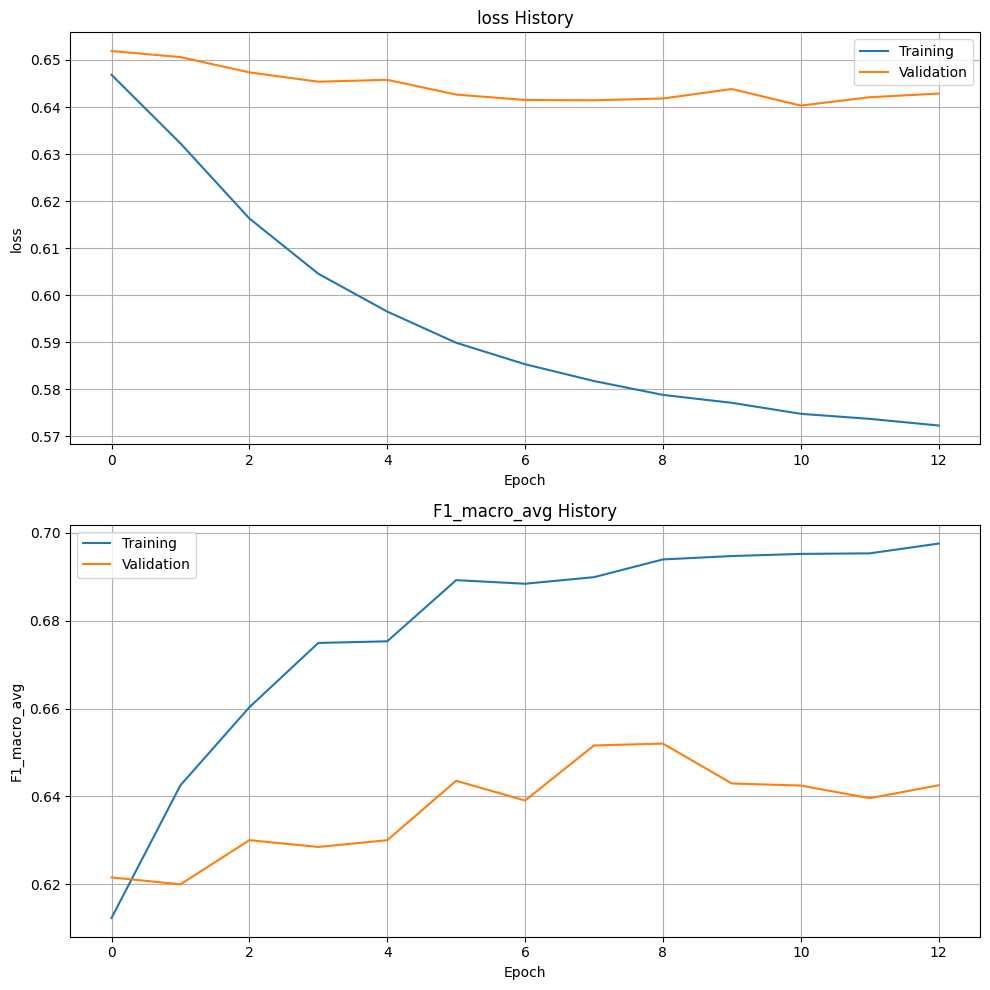

In [13]:
plot_history(bert1_history)

#### 4) Bert w/CP

In [11]:
if FIT_BERTWO:
    optimizer_test = OptimizerWrapper(torch.optim.Adam, identifier=f'lr={1e-6}', optimizer_partial_params={'lr': 1e-6})          
    criterion_test = Criterion('loss', loss_function=torch.nn.BCEWithLogitsLoss(reduction='none'), reduction_function=torch.mean)
    
    bert2 = BerTwo(dropout_prob=0.3, hidden_size= 768, bert_version='roberta-base', bert_constructor=transformers.RobertaModel).to(device)
    
    bert2_history = bert2.fit(train_loader=dataloaders['roberta-base']['CP']['train'], 
                              val_loader=dataloaders['roberta-base']['CP']['val'], 
                              criterion=criterion_test, 
                              metrics=[F1_Score_Multi_Labels('F1_macro_avg', num_labels=N_LABELS, num_classes=N_CLASSES)], 
                              optimizer=optimizer_test,
                              early_stopper=EarlyStopper(monitor='F1_macro_avg', patience=4, delta=0, mode='max', restore_weights=True),
                              num_epochs=200)
    

#### 5) Bert w/CPS

In [12]:
if FIT_BERTHREE:
    optimizer_test = OptimizerWrapper(torch.optim.Adam, identifier=f'lr={1e-6}', optimizer_partial_params={'lr': 1e-6})          
    criterion_test = Criterion('loss', loss_function=torch.nn.BCEWithLogitsLoss(reduction='none'), reduction_function=torch.mean)
    
    bert3 = BerThree(dropout_prob=0.3, hidden_size= 768, bert_version='roberta-base', bert_constructor=transformers.RobertaModel).to(device)
    
    bert3_history = bert3.fit(train_loader=dataloaders['roberta-base']['CPS']['train'], 
                              val_loader=dataloaders['roberta-base']['CPS']['val'], 
                              criterion=criterion_test, 
                              metrics=[F1_Score_Multi_Labels('F1_macro_avg', num_labels=N_LABELS, num_classes=N_CLASSES)], 
                              optimizer=optimizer_test,
                              early_stopper=EarlyStopper(monitor='F1_macro_avg', patience=4, delta=0, mode='max', restore_weights=True),
                              num_epochs=200)
    

 Epoch: 1/10 Iterations: 675/675 Time: 228.165s - loss: 0.631562829017639 - F1_macro_avg: 0.640598583937364 - val_loss: 0.65085756778717 - val_F1_macro_avg: 0.616415056308666 
 Epoch: 2/10 Iterations: 675/675 Time: 228.55s - loss: 0.611115515232086 - F1_macro_avg: 0.669361836044251 - val_loss: 0.644732236862183 - val_F1_macro_avg: 0.634359010870163 
 Epoch: 3/10 Iterations: 675/675 Time: 228.407s - loss: 0.596520721912384 - F1_macro_avg: 0.679985521111272 - val_loss: 0.636972665786743 - val_F1_macro_avg: 0.6456911217218 
 Epoch: 4/10 Iterations: 675/675 Time: 228.656s - loss: 0.579547941684723 - F1_macro_avg: 0.696843100072342 - val_loss: 0.627235233783722 - val_F1_macro_avg: 0.661217992450717 
 Epoch: 5/10 Iterations: 675/675 Time: 228.371s - loss: 0.564381182193756 - F1_macro_avg: 0.714298124304912 - val_loss: 0.617979526519775 - val_F1_macro_avg: 0.668093739867831 
 Epoch: 6/10 Iterations: 675/675 Time: 228.747s - loss: 0.551492869853973 - F1_macro_avg: 0.726471985758013 - val_loss:

In [ ]:
### Test sul modello

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config=transformers.BertConfig.from_pretrained('bert-base-uncased')
text = "Replace me by any text you'd like pollo."
encoded_input = tokenizer(text, return_tensors='pt')

model = transformers.BertModel.from_pretrained("bert-base-uncased")
output = model(**encoded_input)
print(model.config)
"""p_d = BertOne()
output1 = p_d(**encoded_input)"""


In [ ]:
from torch.nn.functional import max_pool2d

print(output[0].shape)
output_2 = max_pool2d(output[0], kernel_size=(14,1))

output_2[:,0,:].shape

In [13]:
tensor1 = torch.randn(8, 768)
tensor2 = torch.randn(8, 768)
tensor3 = torch.randn(8)

# Aggiungi una dimensione al tensor3 per renderlo 2D
tensor3 = tensor3.unsqueeze(1)

# Concatena i tensori lungo la seconda dimensione
risultato = torch.cat((tensor1, tensor2, tensor3), dim=1)

# Verifica le dimensioni del risultato
print(risultato.size())

torch.Size([8, 1537])


In [13]:
import transformers 
type(transformers.BertTokenizer)

type

In [ ]:
model_inputs = {"C":["Conclusion"], "CP":["Conclusion", "Premise"], "CPS":["Conclusion", "Premise", "Stance"]}

dataloader_train_C, dataloader_val_C, dataloader_test_C  = build_dataloaders(train_df=train_arg_df, 
                                                                             val_df=val_arg_df, 
                                                                             test_df=test_arg_df, 
                                                                             train_labels_df=train_labels_df, 
                                                                             val_labels_df=val_labels_df, 
                                                                             test_labels_df=test_labels_df, 
                                                                             one_hot_mapping=CLASS_2_ONE_HOT, 
                                                                             bert_version="bert-base-uncased", 
                                                                             model_input=model_inputs["C"],
                                                                             custom_dataset_builder=CustomDataset_C,
                                                                             batch_size=BATCH_SIZE_C, 
                                                                             shuffle=True)

dataloader_train_CP, dataloader_val_CP, dataloader_test_CP  = build_dataloaders(train_df=train_arg_df, 
                                                                                val_df=val_arg_df, 
                                                                                test_df=test_arg_df, 
                                                                                train_labels_df=train_labels_df, 
                                                                                val_labels_df=val_labels_df, 
                                                                                test_labels_df=test_labels_df, 
                                                                                one_hot_mapping=CLASS_2_ONE_HOT, 
                                                                                bert_version="bert-base-uncased", 
                                                                                model_input=model_inputs["CP"],
                                                                                custom_dataset_builder=CustomDataset_CP,
                                                                                batch_size=BATCH_SIZE_CP, 
                                                                                shuffle=True)

dataloader_train_CPS, dataloader_val_CPS, dataloader_test_CPS  = build_dataloaders(train_df=train_arg_df, 
                                                                                   val_df=val_arg_df, 
                                                                                   test_df=test_arg_df, 
                                                                                   train_labels_df=train_labels_df, 
                                                                                   val_labels_df=val_labels_df, 
                                                                                   test_labels_df=test_labels_df, 
                                                                                   one_hot_mapping=CLASS_2_ONE_HOT, 
                                                                                   bert_version="bert-base-uncased", 
                                                                                   model_input=model_inputs["CPS"],
                                                                                   custom_dataset_builder=CustomDataset_CPS,
                                                                                   batch_size=BATCH_SIZE_CPS, 
                                                                                   shuffle=True)






In [13]:
rt = transformers.RobertaTokenizer.from_pretrained('bert_models/roberta-base')
rt.encode_plus('hello',return_token_type_ids=True)

{'input_ids': [0, 42891, 2], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

In [12]:
rt = transformers.BertTokenizer.from_pretrained('bert_models/bert-base-uncased')
rt.encode_plus('hello',return_token_type_ids=True)

{'input_ids': [101, 7592, 102], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}